In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
from matplotlib.patches import Rectangle
import torch

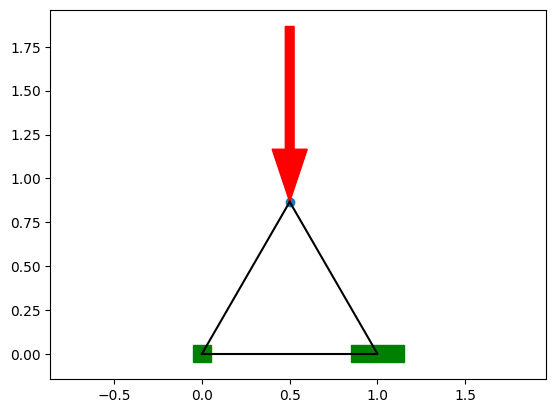

In [196]:
class Truss:
    def __init__(self, nodes : np.ndarray, edges : np.ndarray) -> None:
        """Nodes: Nx2 np array of X,Y coord pairs.
        Edges: Mx2 array of (i,j) edge pairs"""
        self.n_nodes = len(nodes)
        self.n_edges = len(edges)
        assert nodes.shape == (self.n_nodes, 2)
        assert edges.shape == (self.n_edges, 2)

        # nodes are stored as list of tensors so that some can require gradients, but others not
        self.node_tensors = [torch.tensor(node, requires_grad=True) for node in nodes]
        self.edges = edges
        self.loads = []
        self.anchors : list[tuple] = []
        self.forces = None
        self._validate_edges()
    
    def _validate_edges(self):
        """Validates that all edges make sense and have no duplicates"""
        edge_set = set()
        for i, j in self.edges:
            assert 0 <= i < self.n_nodes, f"index error: {i}"
            assert 0 <= j < self.n_nodes, f"index error for {j}"
            edge = frozenset((i, j))
            assert edge not in edge_set, f"Duplicate edge {(i,j)}!"
            edge_set.add(edge)
    
    def add_load(self, idx, fx, fy):
        """Adds a force acting on the given node"""
        assert 0 <= idx < self.n_nodes
        self.loads.append((idx, fx, fy))
        self.node_tensors[idx].requires_grad = False

    def add_anchor(self, idx : int, x : bool = True, y : bool = True):
        """Sets node at idx to be an anchor in possibly the x and y dimensions.
        An anchor node does not need to reach equilibrium, because any
        excess force will be taken in by the ground. It should not be
        included in the system of equations!"""
        assert 0 <= idx < self.n_nodes
        self.anchors.append((idx, x, y))
        self.node_tensors[idx].requires_grad = False
    
    def draw(self) -> None:
        fig, ax = plt.subplots()
        plt.axis('equal')

        # get values out of tensor list
        xs = np.array([n[0].detach() for n in self.node_tensors])
        ys = np.array([n[1].detach() for n in self.node_tensors])

        # draw nodes
        plt.scatter(xs, ys)
        
        # draw edges
        if self.forces is None:
            for i, j in self.edges:
                plt.plot(xs[[i, j]], ys[[i, j]] , 'k-')
        else:
            for (i, j), f in zip(self.edges, self.forces):
                color = 'r' if f > 0 else 'b'
                plt.plot(
                    xs[[i, j]], ys[[i, j]], 
                    f'{color}-',
                    linewidth=abs(f))

        # draw loads
        for idx, fx, fy in self.loads:
            fx /= 10
            fy /= 10
            plt.arrow(xs[idx] - fx, ys[idx] - fy, fx, fy,  # subtract force to put tip at node
                head_width = 0.2,
                width = 0.05,
                color='red',
                length_includes_head=True)
            
        # draw anchors
        for idx, x_constrained, y_constrained in self.anchors:
            constrained_size = 0.1
            unconstrained_size = 0.3
            width = constrained_size if x_constrained else unconstrained_size
            height = constrained_size if y_constrained else unconstrained_size
            center = (xs[idx] - width / 2, ys[idx] - height / 2)
            ax.add_patch(Rectangle(center, width, height, edgecolor="green", facecolor="green"))
            
    def _get_unit_xy(self, dx, dy):
        """Return the unit components of x, y normalized by total vector length"""
        hypot = torch.sqrt(dx**2 + dy**2)
        return dx / hypot, dy / hypot

    def calculate_forces(self):
        """Computes the force on each beam!
        Construct a matrix A representing system of equations, and solve.
        A @ Force_Vec = Load_vec
        Positive forces are compression, negative are tension.
        """

        # create design matrix
        A = torch.zeros((2 * self.n_nodes, self.n_edges))
        for edge_i, (n1_i, n2_i) in enumerate(self.edges):

            n1x, n1y = self.node_tensors[n1_i]
            n2x, n2y = self.node_tensors[n2_i]
            ux, uy = self._get_unit_xy(n1x - n2x, n1y - n2y)

            # towards N1
            A[n1_i * 2][edge_i], A[n1_i * 2 + 1][edge_i] = ux, uy

            # towards N2
            A[n2_i * 2][edge_i], A[n2_i * 2 + 1][edge_i] = -ux, -uy

        # construct load vector
        load_vec = torch.zeros((2 * self.n_nodes, 1))  # stored as [x1,y1,x2,y2...]
        for idx, fx, fy in self.loads:
            load_vec[idx * 2] += fx
            load_vec[idx * 2 + 1] += fy
        
        # handle anchor points: anchor points can have any force, so they can simply be
        # removed from the system of equations!
        # Zeroing instead of removing to preserve indexing...
        for node_idx, x, y in self.anchors:
            if x:
                A[node_idx * 2, :] = 0.0
                load_vec[node_idx * 2] = 0.0  # loads on anchor points are irrelevant
            if y:
                A[node_idx * 2 + 1, :] = 0.0
                load_vec[node_idx * 2 + 1] = 0.0  # loads on anchor points are irrelevant
        
        # use gelsd solver to handle non-full rank matrices
        self.forces, residuals, rank, s = torch.linalg.lstsq(A, -load_vec, rcond=None, driver='gelsd')
        
        # print(f"{A=}")
        # print(f"{self.forces=}")
        # print(f"{residuals=}")
        # print(f"{rank=}")
        # print(f"{s=}")
        # print(f"{A@self.forces=}")

        residual_threshold = 0.1
        if len(residuals) > 0 and residuals.item() > residual_threshold:
            raise ValueError("Nodes could not reach equilibrium!")

        return self.forces
    
    def get_cost(self):
        """Calculates the cost of the truss from the lengths and forces.
        Tension weight = length * force / 1
        compression weight = length * force / (3 / (length + 3))
        """

        self.calculate_forces()

        lengths = torch.zeros_like(self.forces)
        for i, (n1, n2) in enumerate(self.edges):
            lengths[i] = torch.linalg.norm(self.node_tensors[n1] - self.node_tensors[n2])
    
        weights = torch.zeros_like(lengths)

        # beams in tension
        weights = lengths * torch.abs(self.forces)

        # compression
        fall_off = 3.0
        weights[self.forces > 0] *= (lengths[self.forces > 0] + fall_off) / fall_off

        return torch.sum(weights)
    
    def get_params(self):
        """Returns a list of all nodes that require a gradient"""
        return [n for n in self.node_tensors if n.requires_grad]
    
# Equilateral triangle test with pure forces
nodes = np.array([
    (0.5, np.sin(2*np.pi/3)),
    (0.0, 0.0), 
    (1.0, 0.0),
])
edges = np.array(((0,1), (1, 2), (2, 0)))
t = Truss(nodes, edges)

t.add_load(0, 0, -10)
t.add_anchor(1)
t.add_anchor(2, x=False)
t.draw()
# cost = t.get_cost()
# print(t.nodes)
# cost.backward()

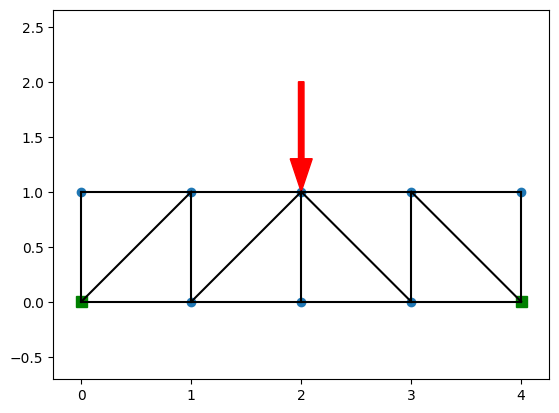

In [436]:
node_tensors = np.array([
    (0.0, 0.0),
    (0.0, 1.0), 
    (1.0, 0.0),
    (1.0, 1.0), 
    (2.0, 0.0),
    (2.0, 1.0), 
    (3.0, 0.0),
    (3.0, 1.0), 
    (4.0, 0.0),
    (4.0, 1.0), 
])
edges = np.array((
    (0,2), (2,4), (4,6), (6,8),
    (1,3), (3,5), (5,7), (7,9),
    (0,1), (2,3), (4,5), (6,7), (8,9),
    (0,3), (2,5), (5,6), (7,8),
))
t = Truss(node_tensors, edges)


t.add_load(5, 0, -10)
t.add_anchor(0)
t.add_anchor(8)
t.draw()

optimizer = torch.optim.Adam(params=t.get_params(), lr=0.01)

KeyboardInterrupt: 

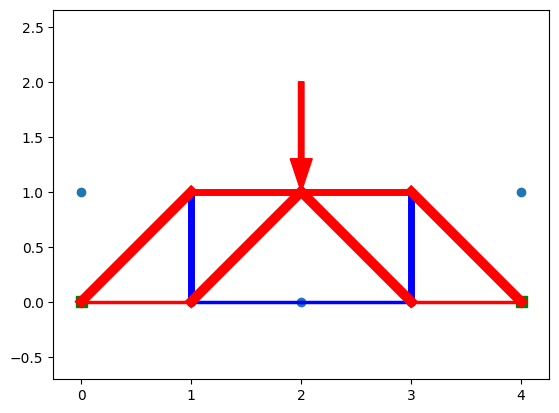

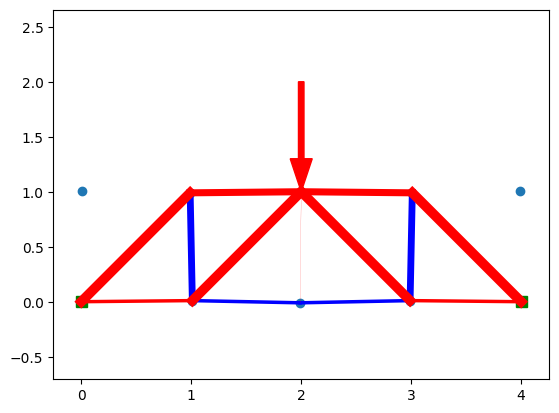

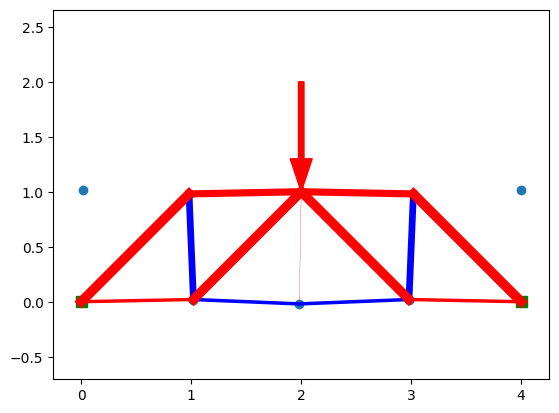

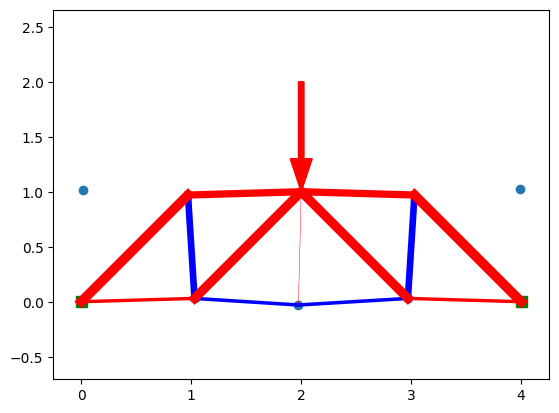

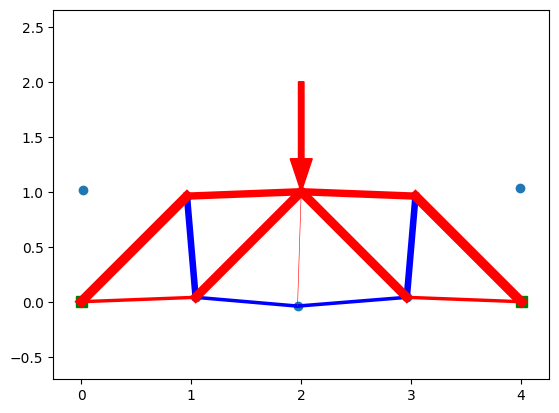

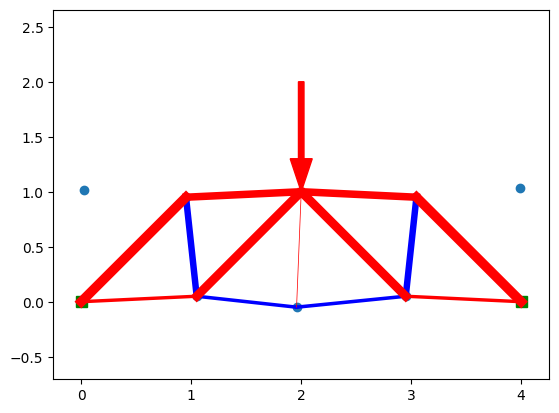

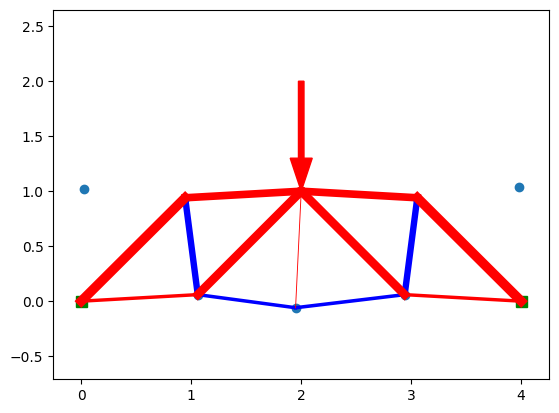

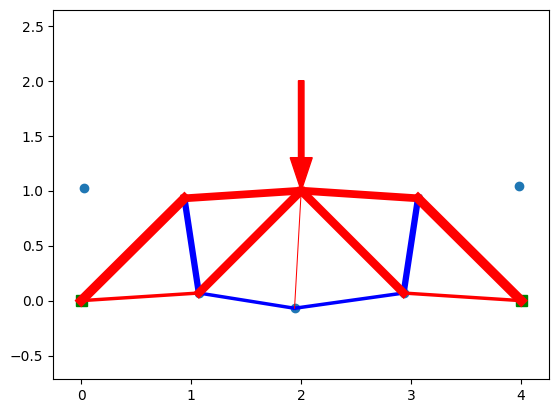

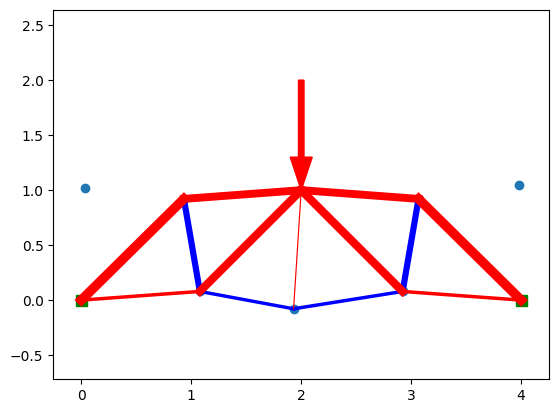

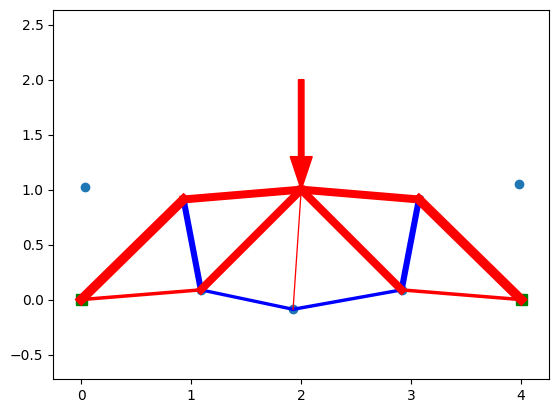

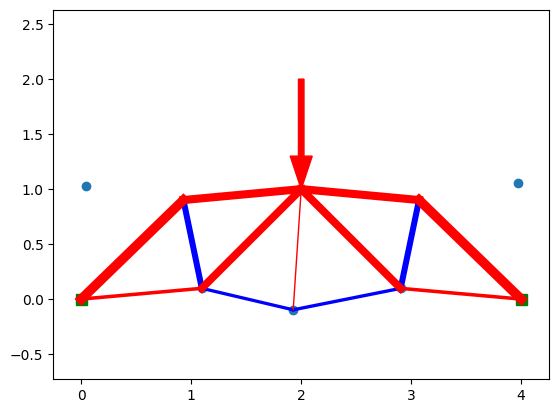

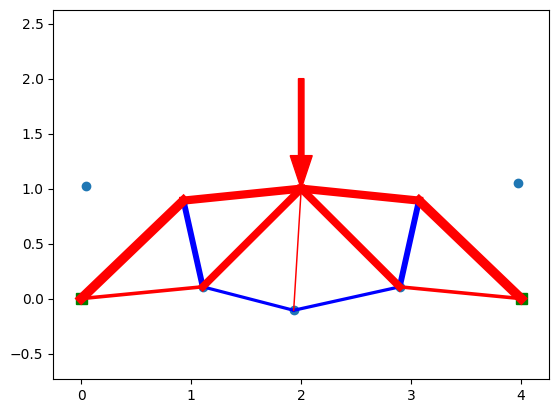

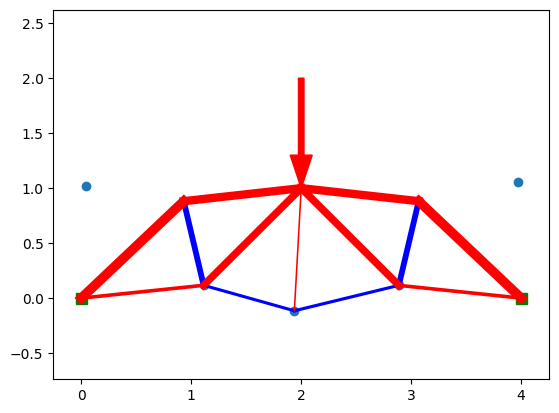

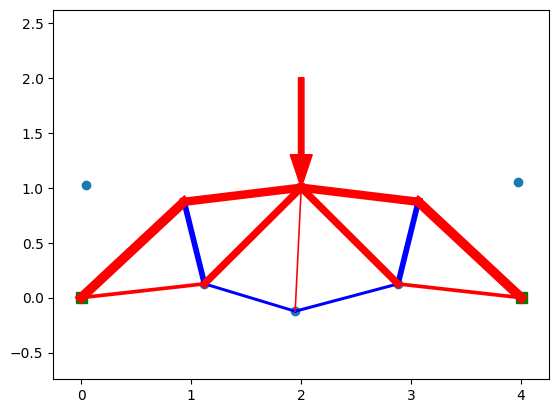

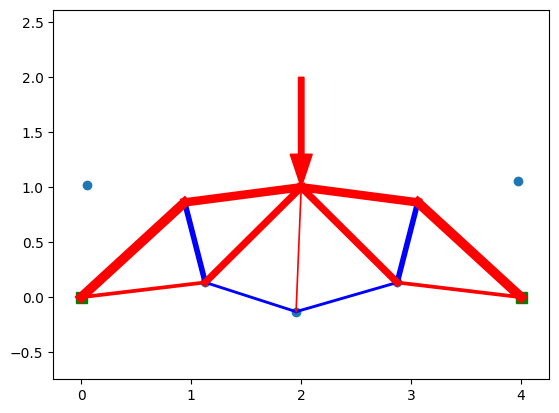

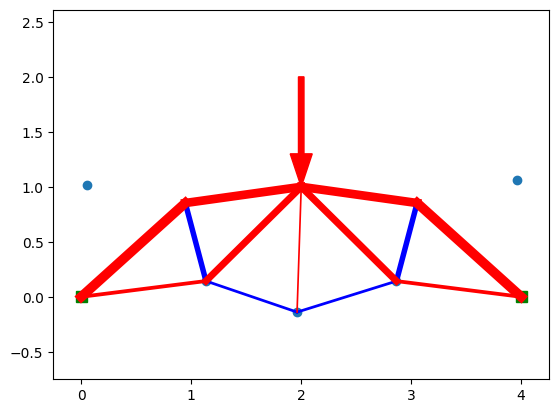

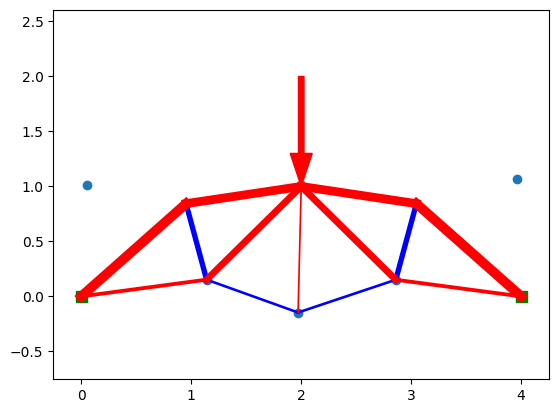

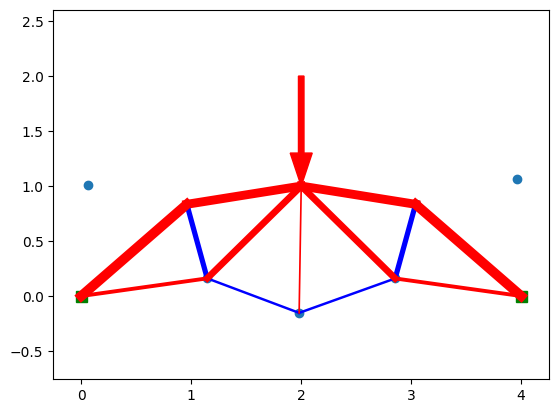

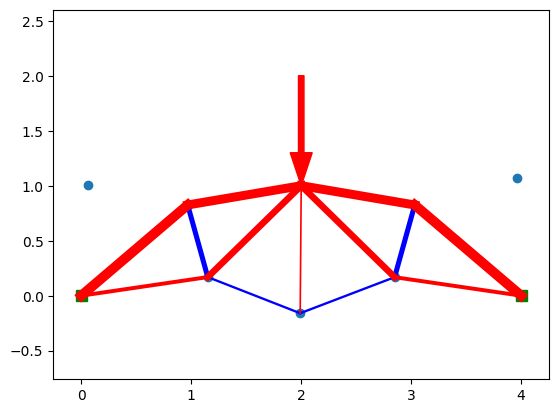

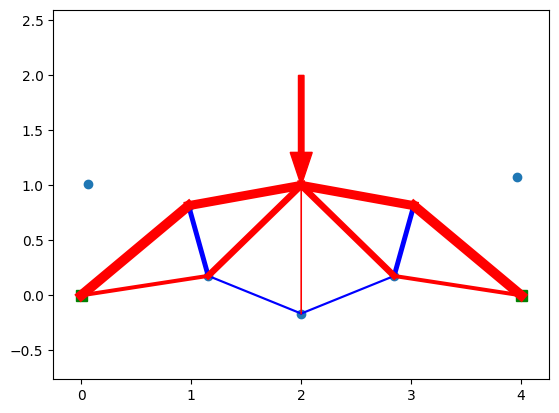

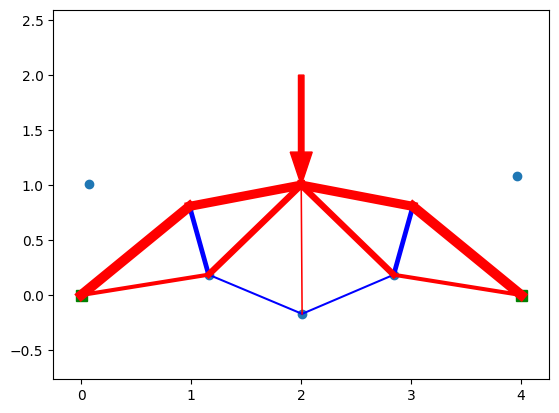

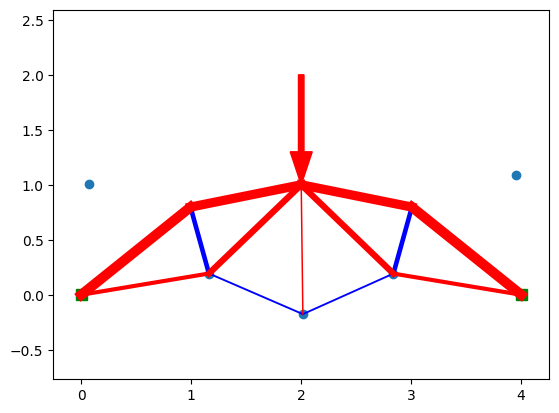

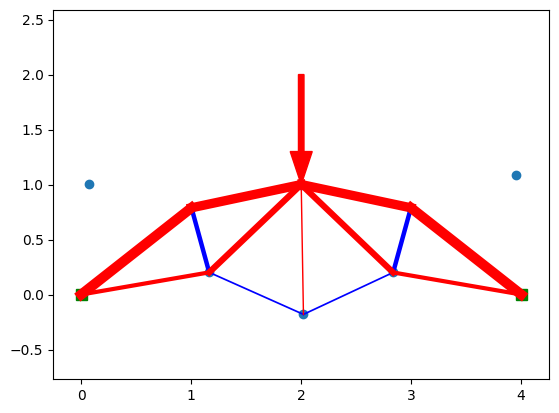

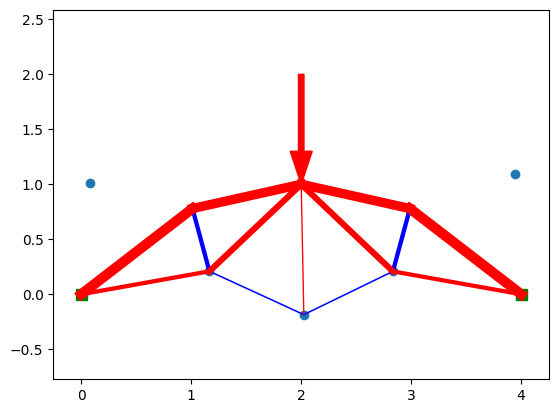

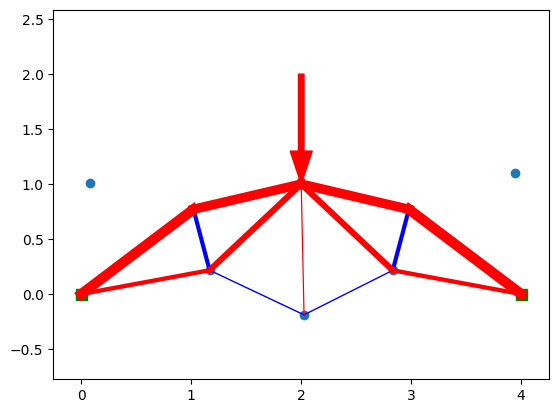

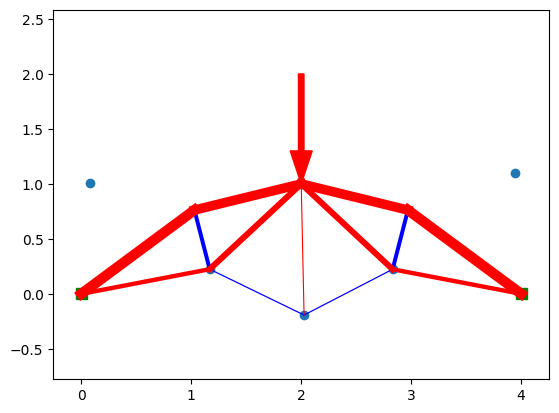

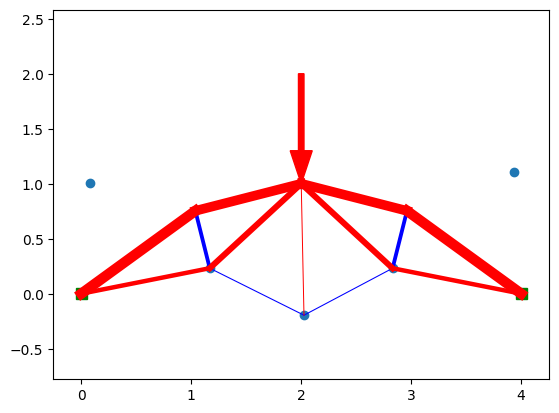

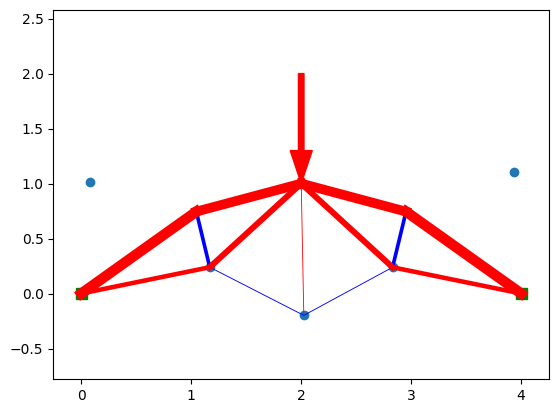

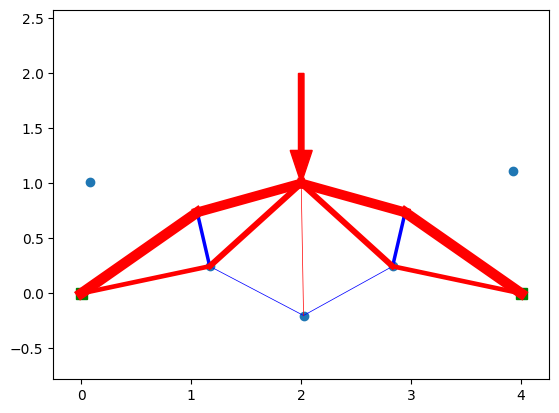

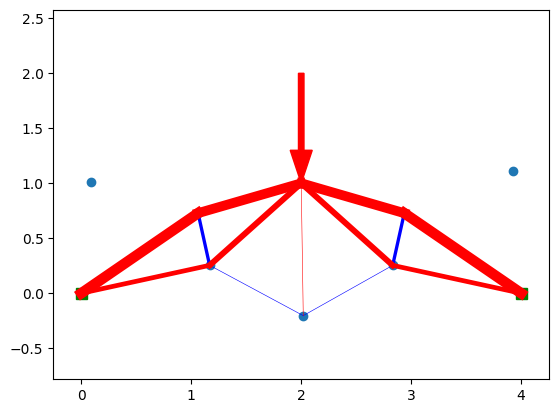

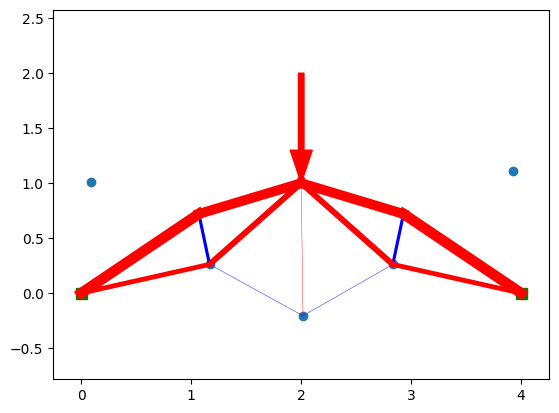

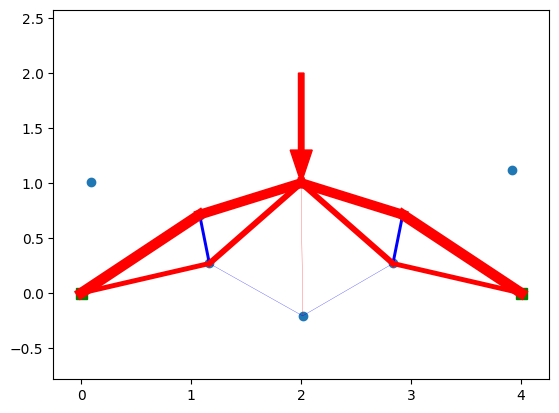

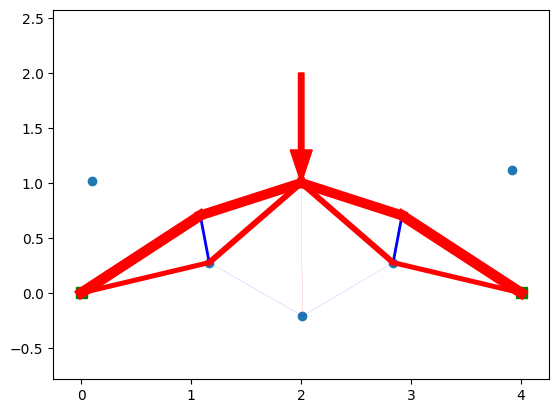

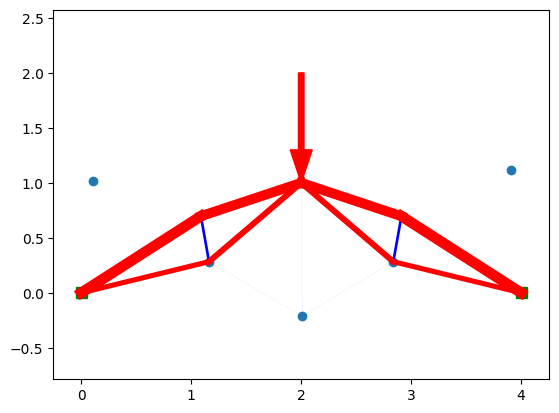

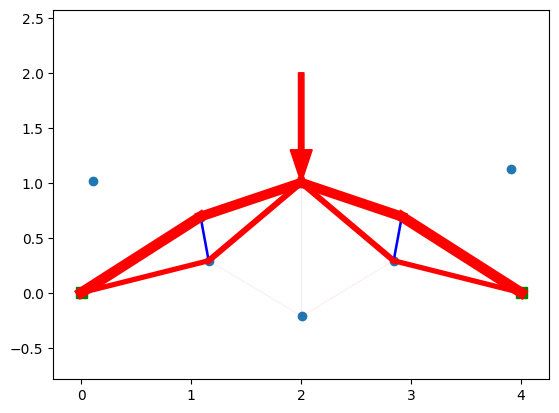

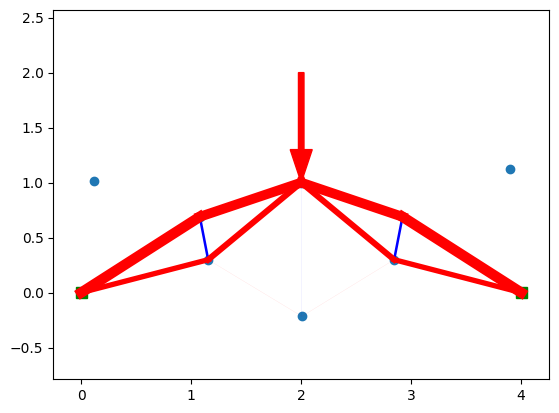

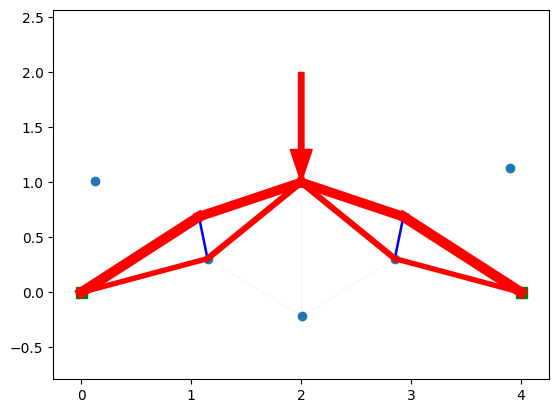

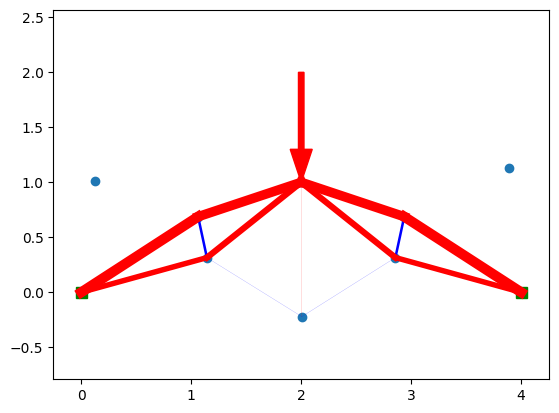

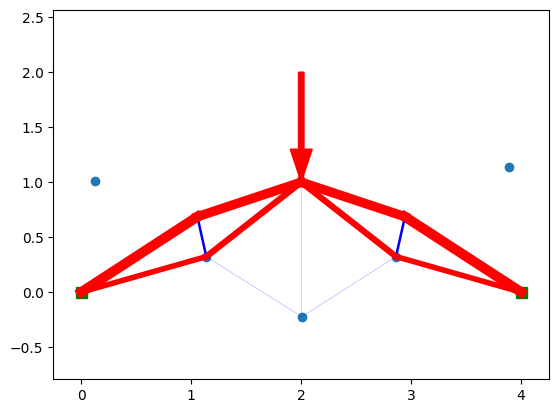

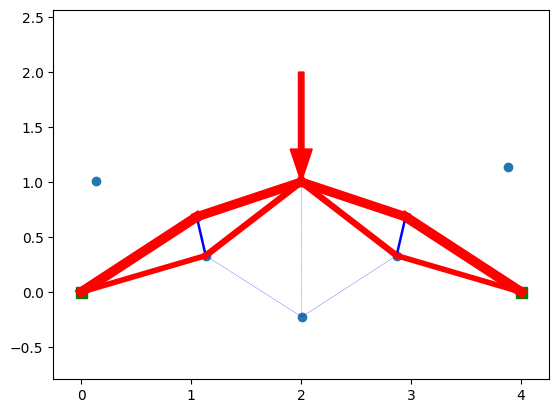

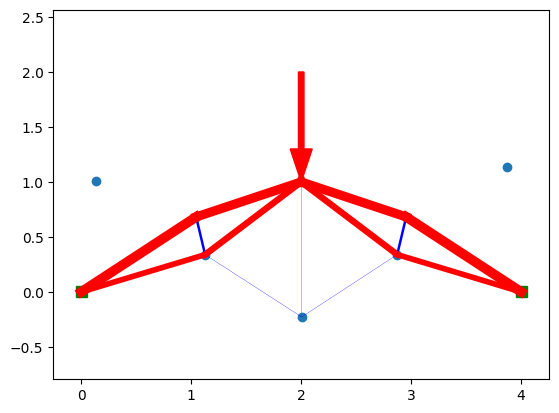

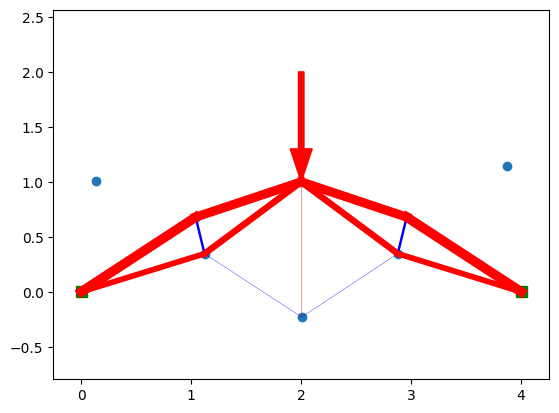

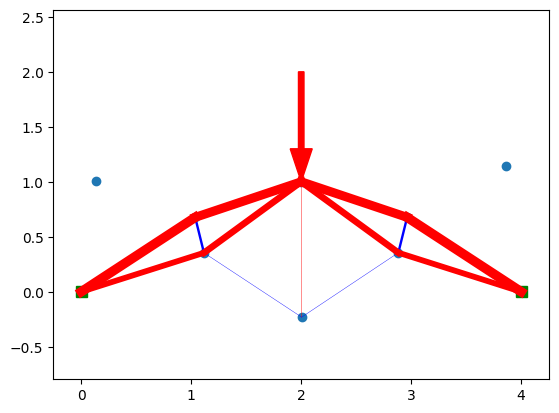

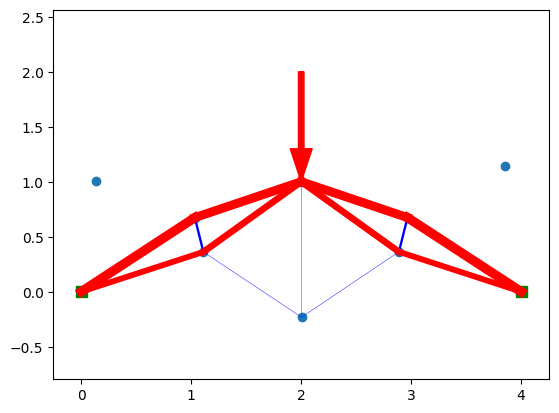

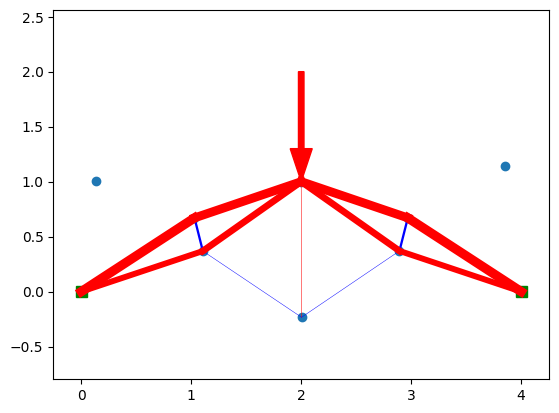

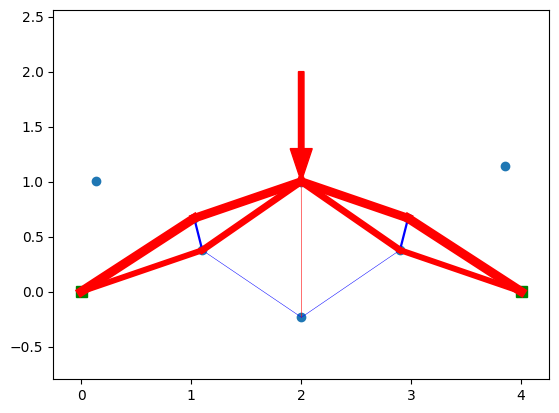

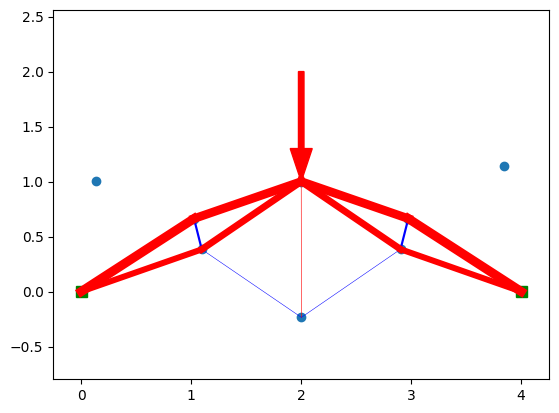

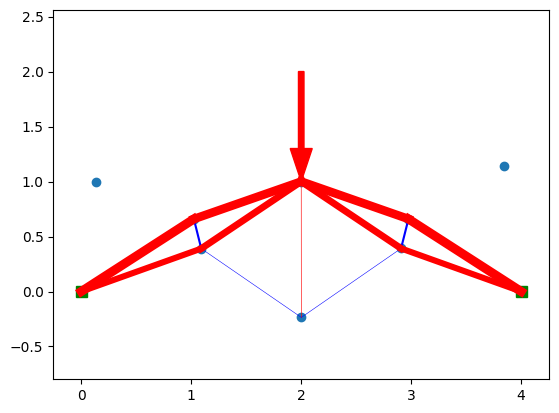

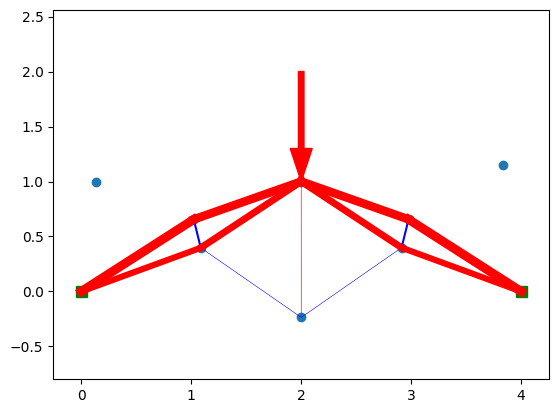

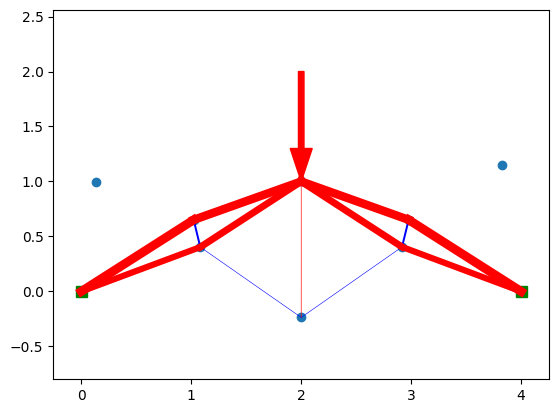

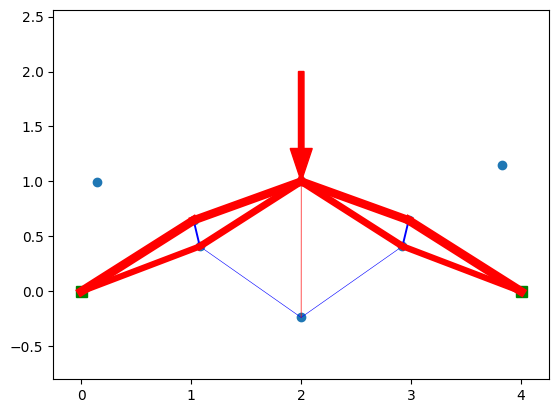

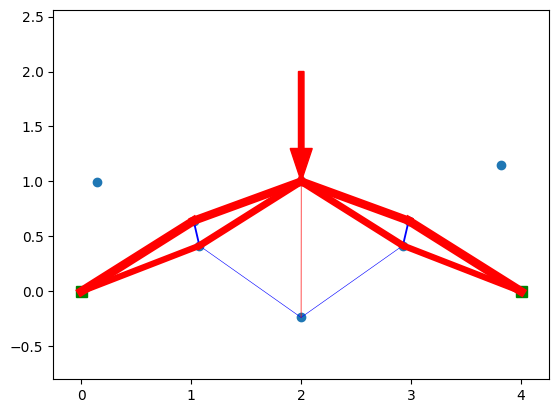

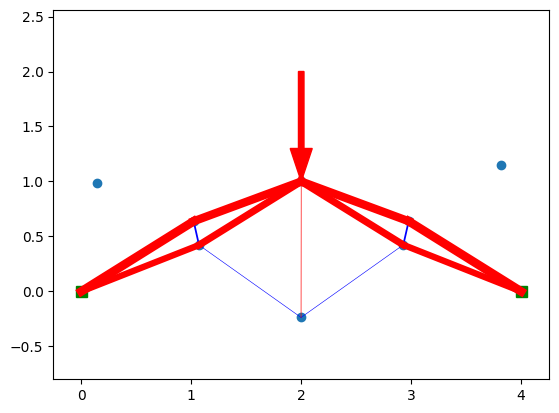

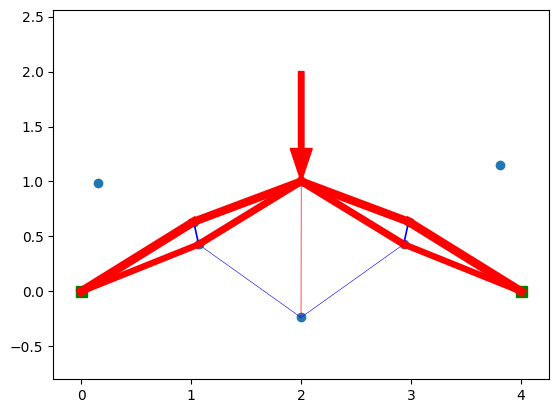

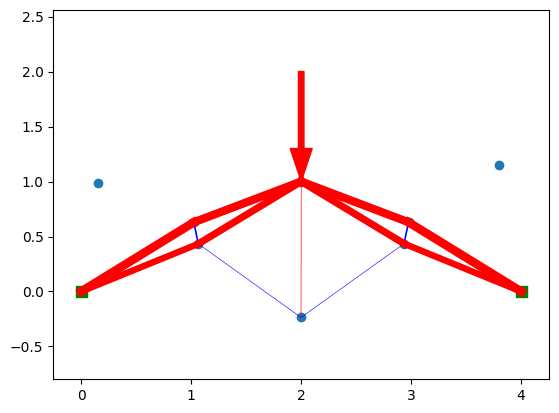

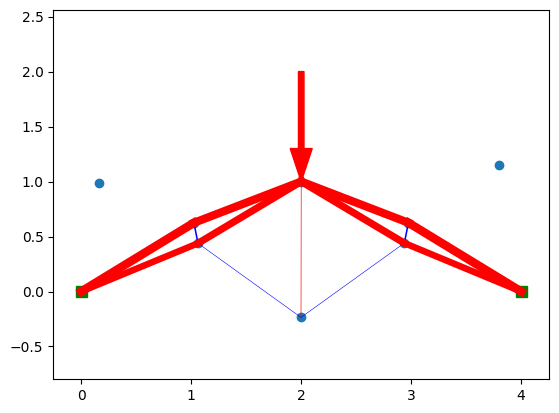

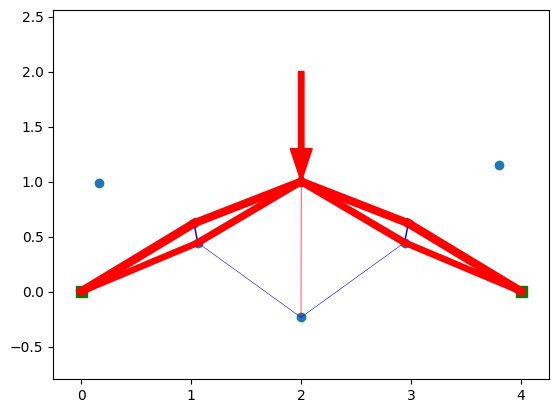

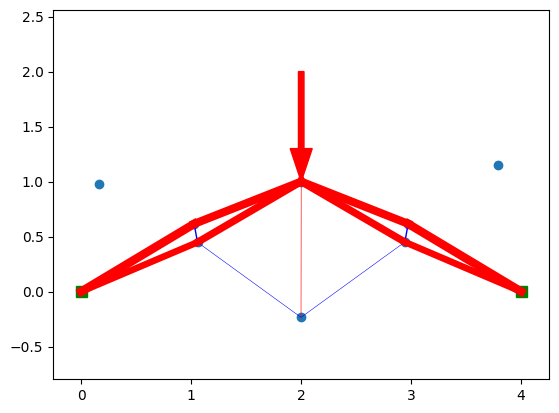

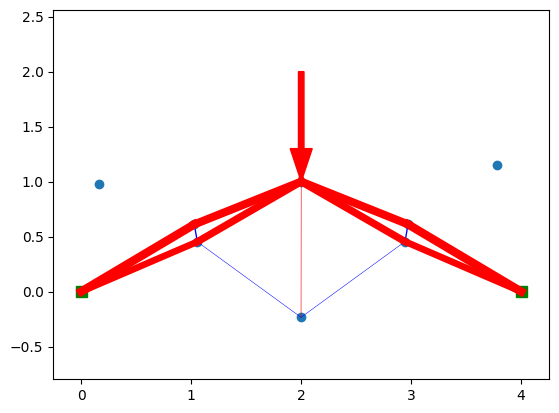

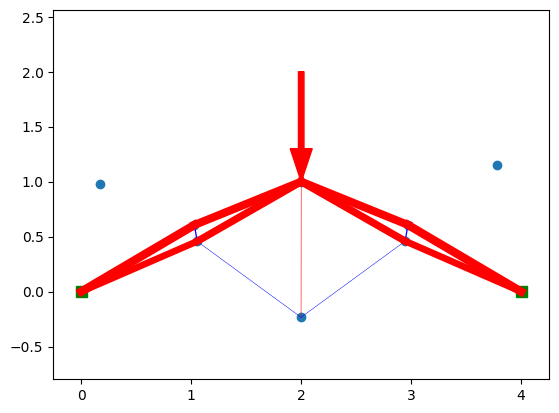

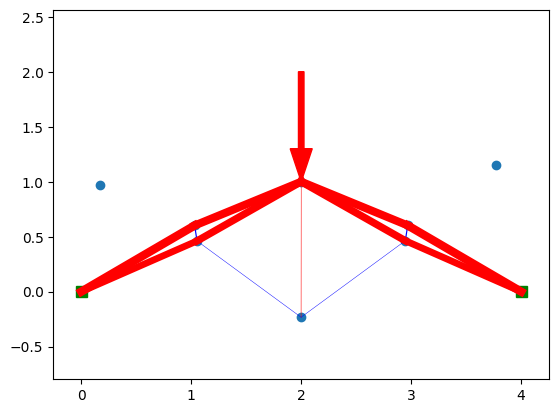

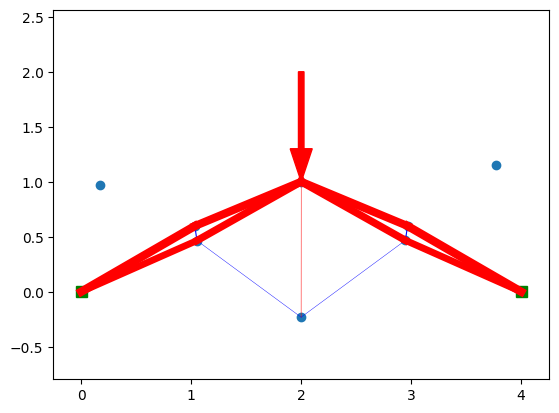

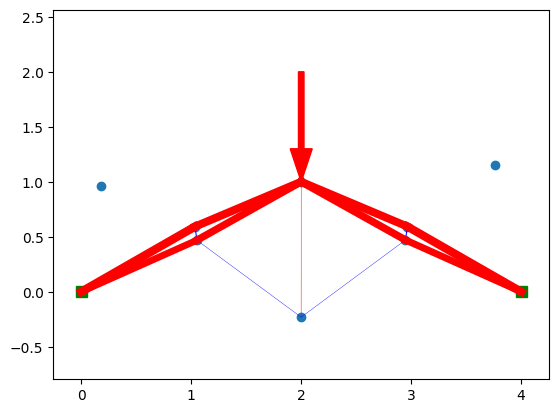

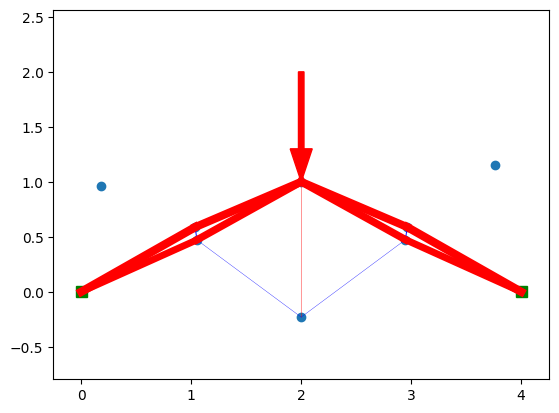

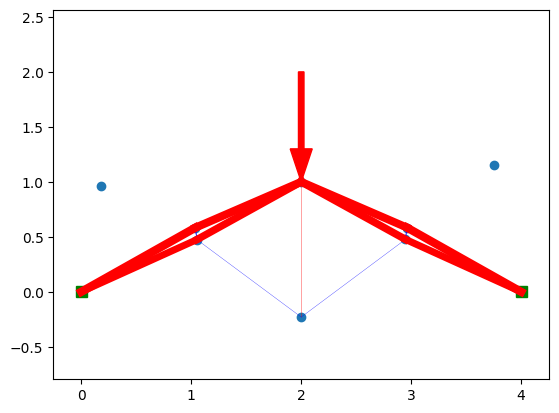

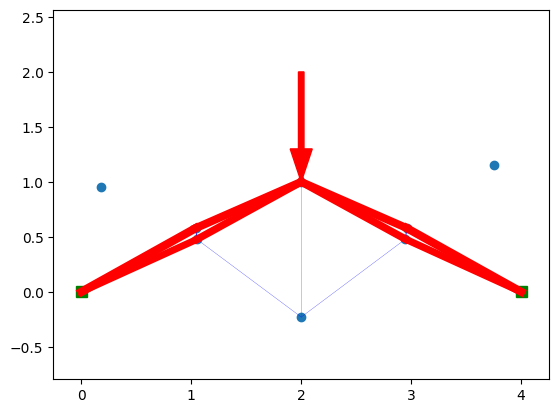

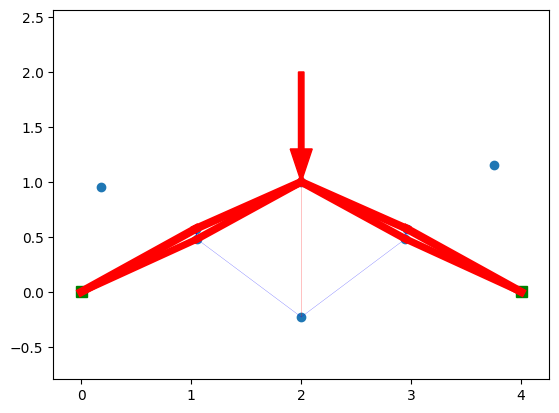

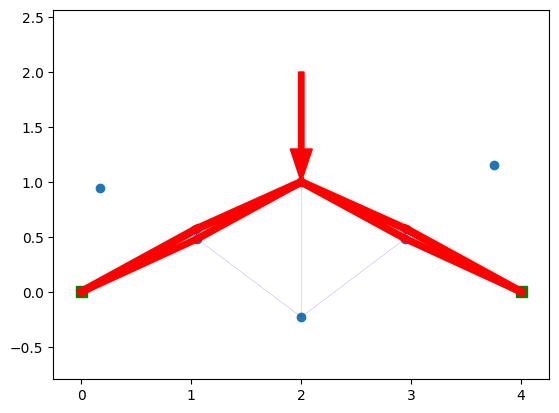

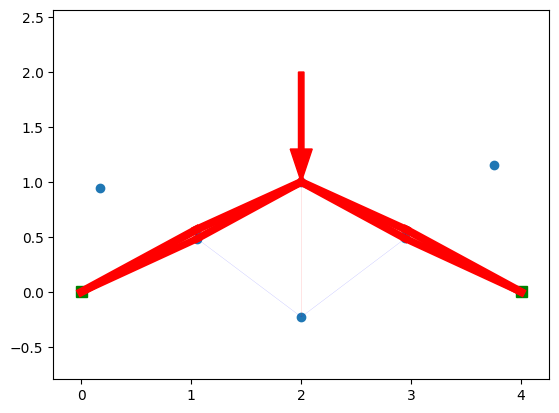

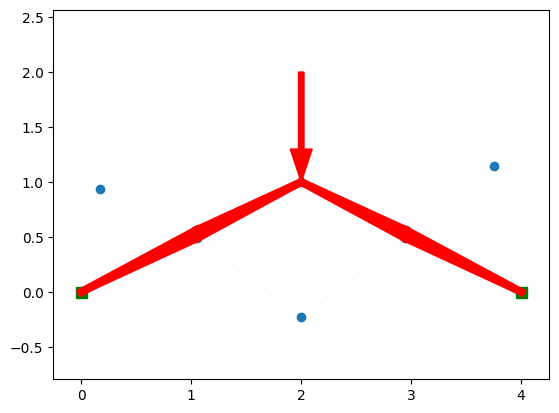

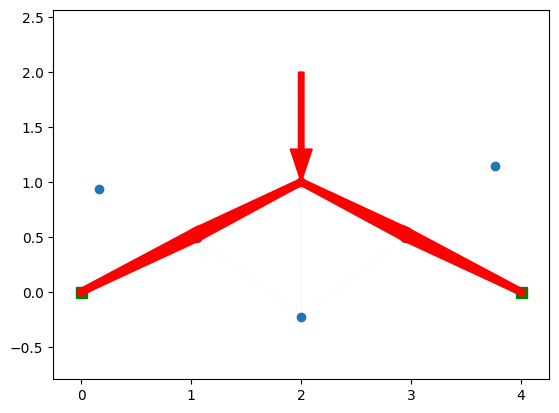

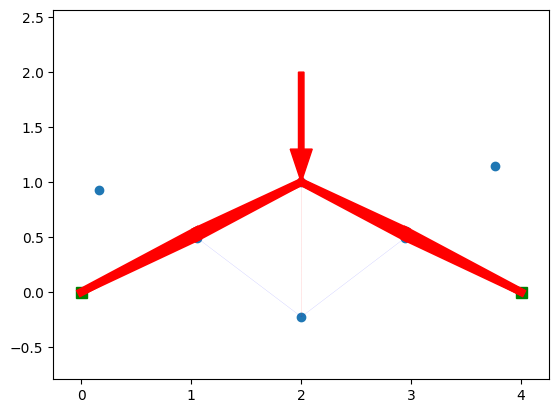

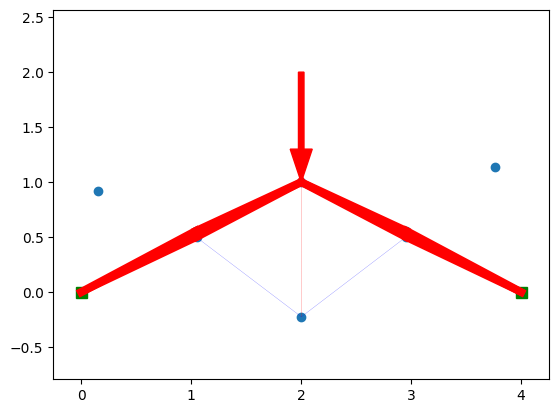

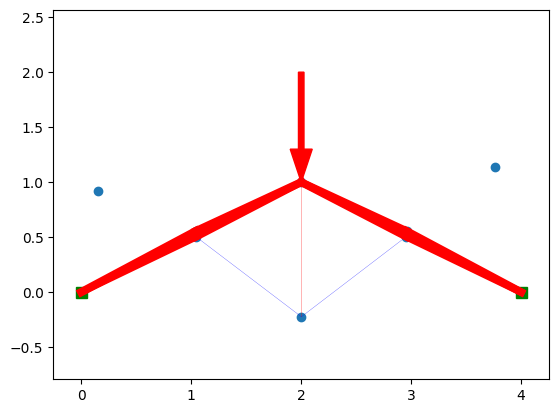

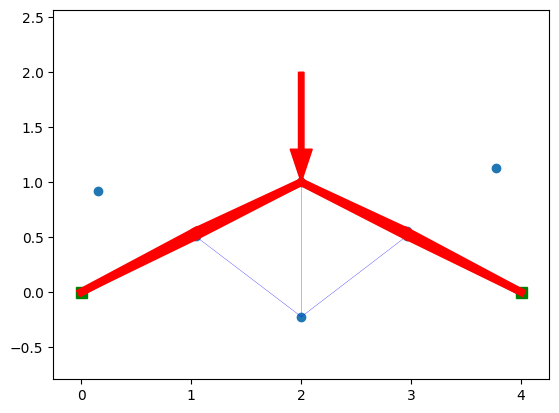

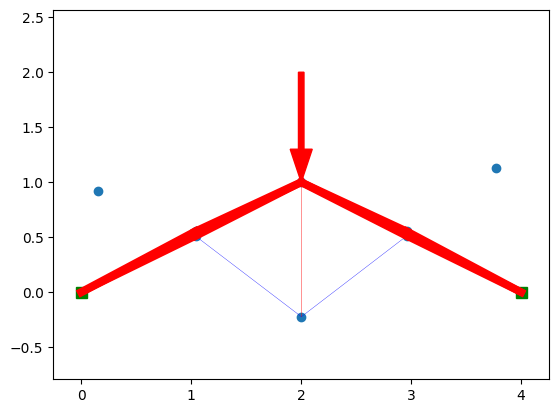

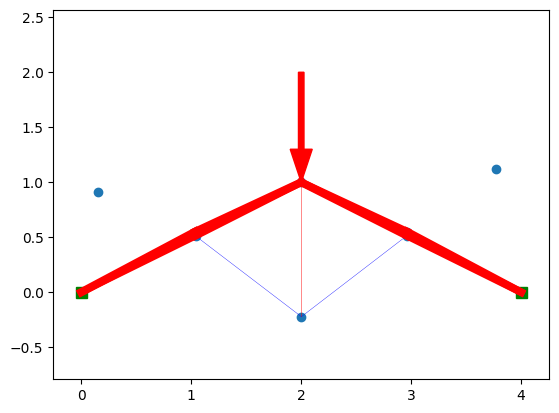

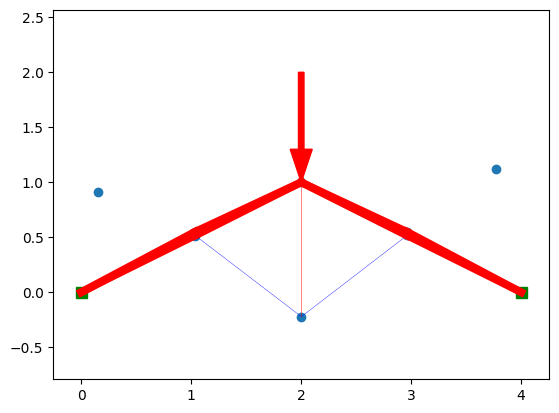

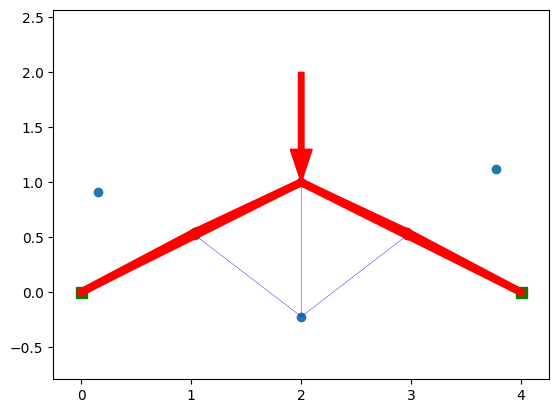

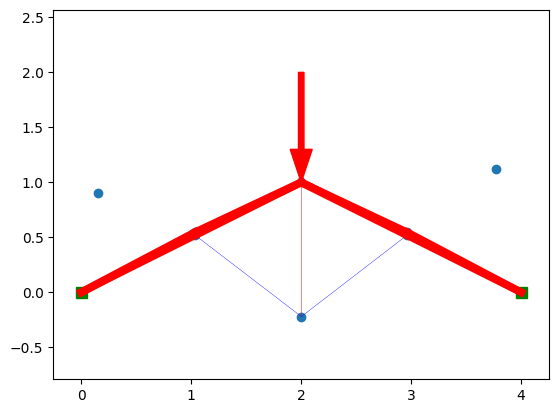

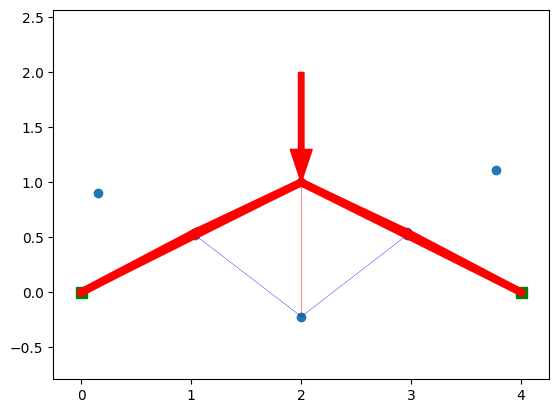

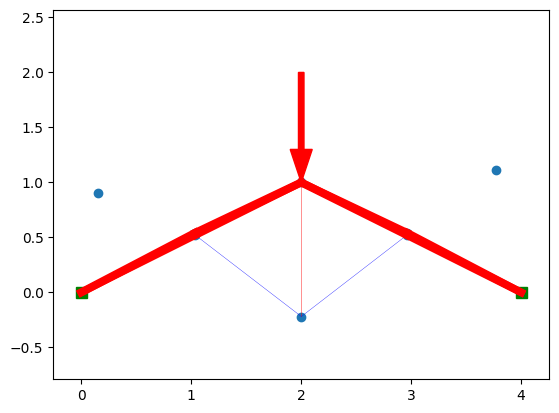

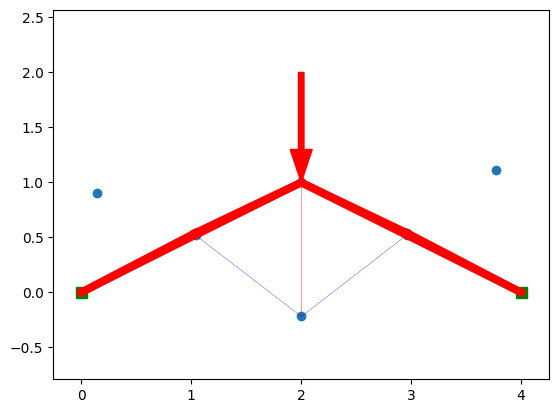

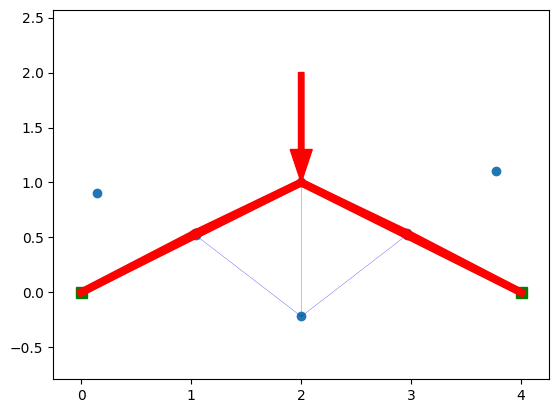

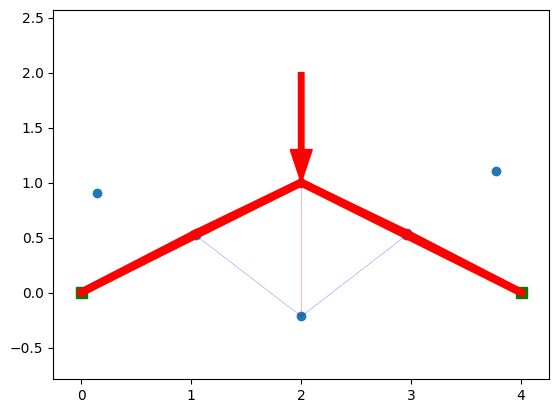

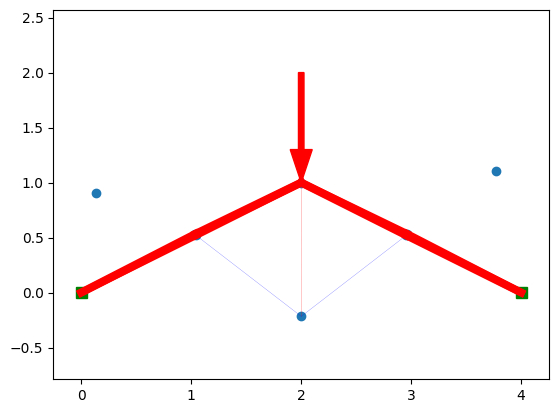

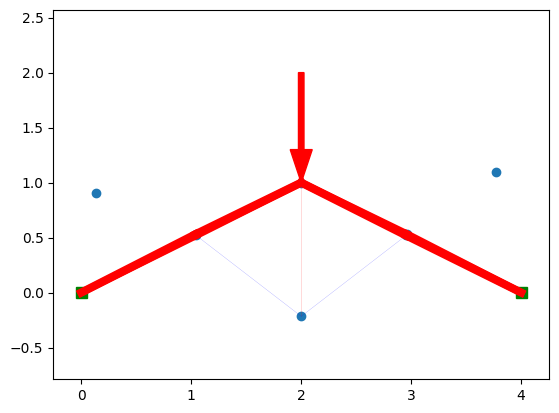

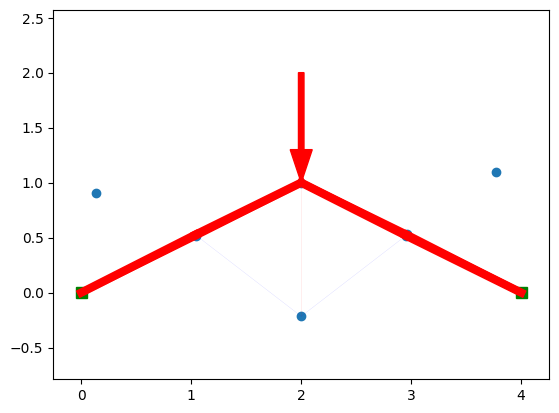

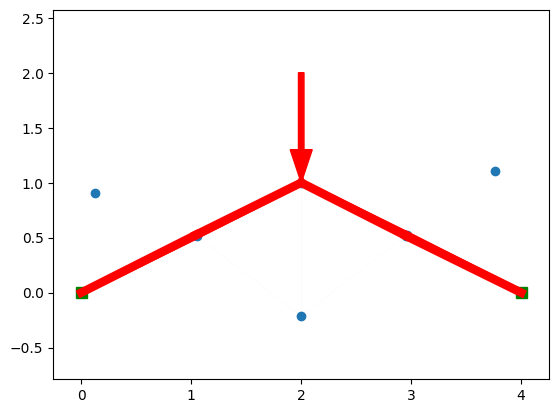

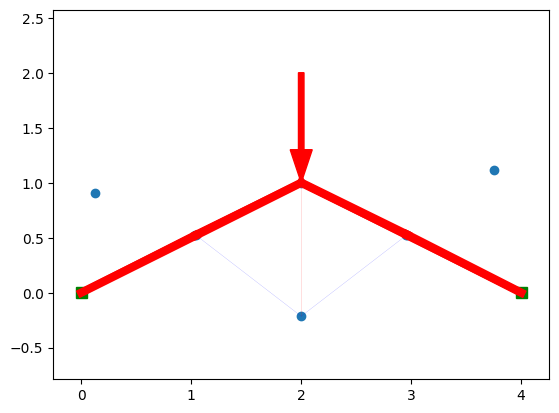

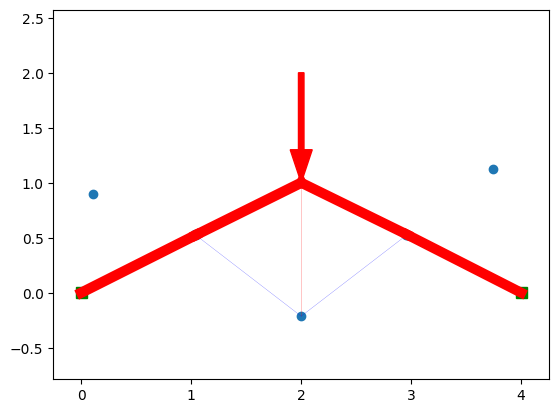

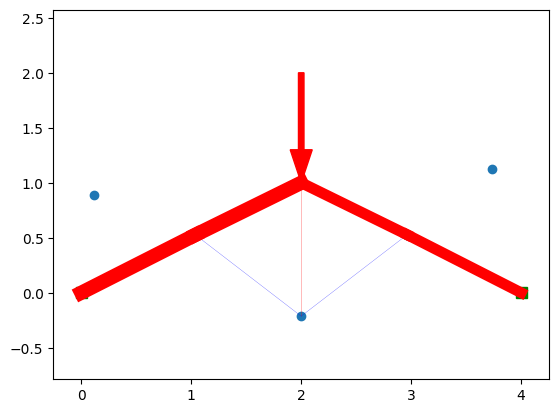

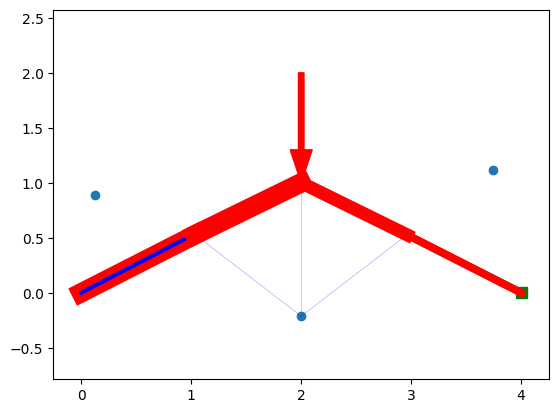

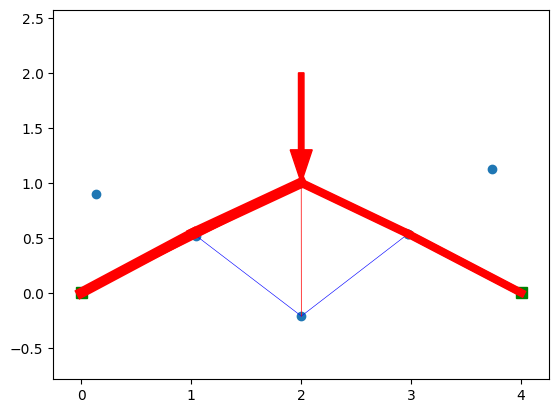

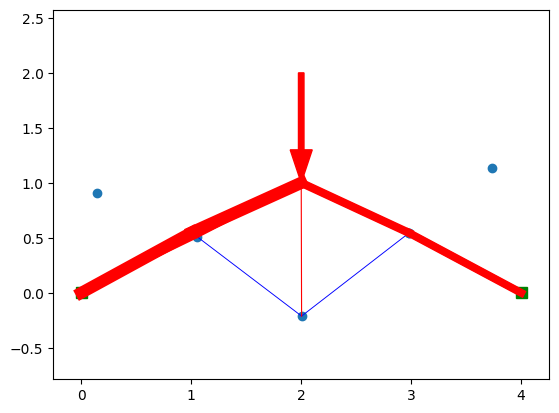

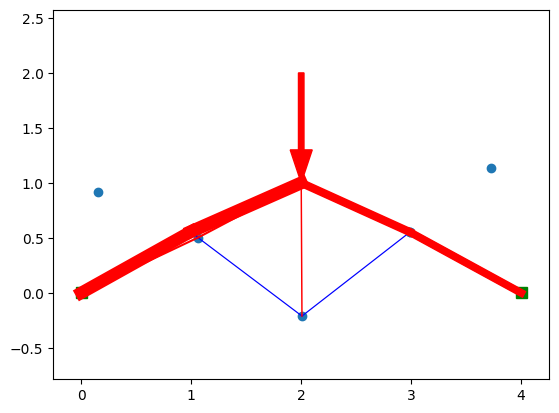

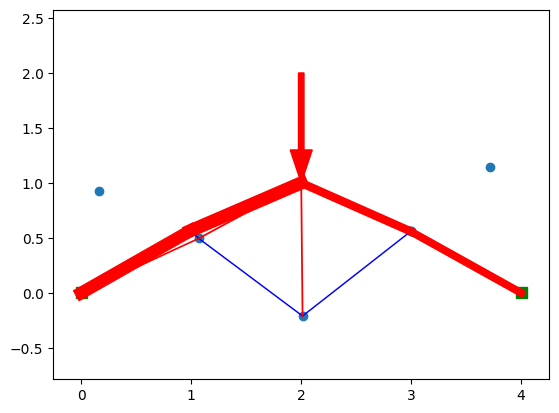

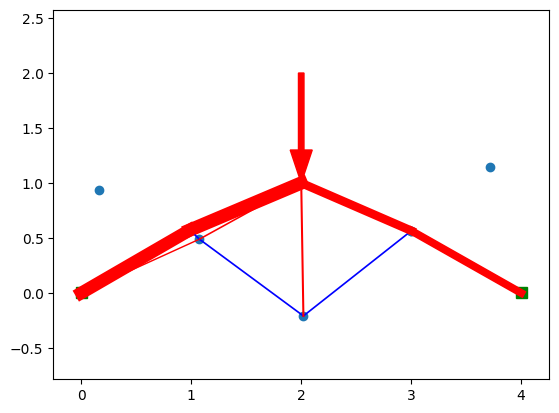

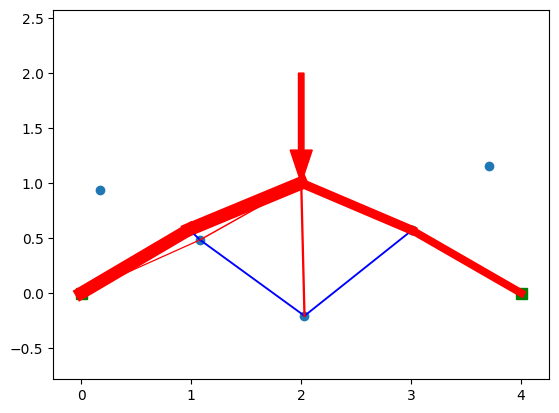

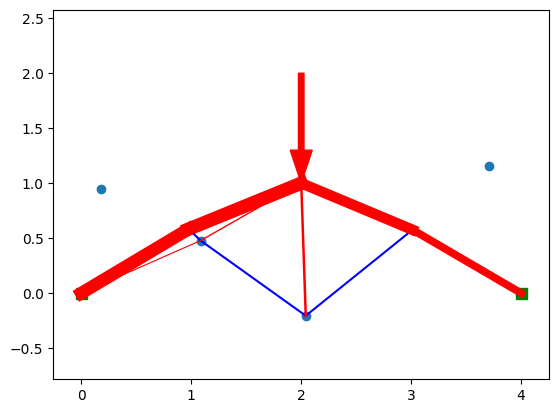

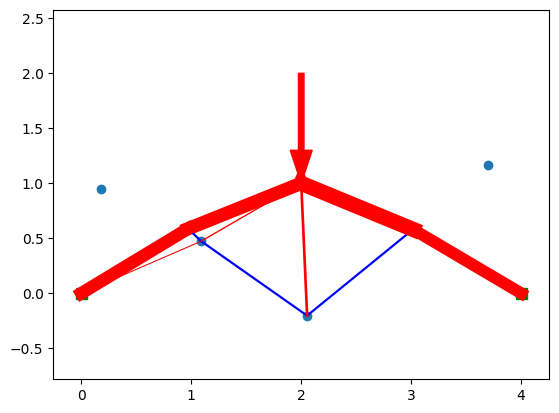

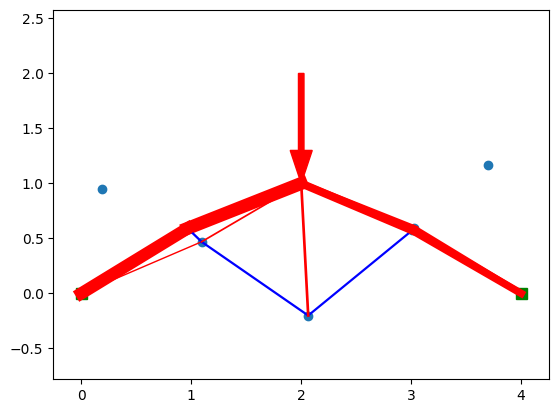

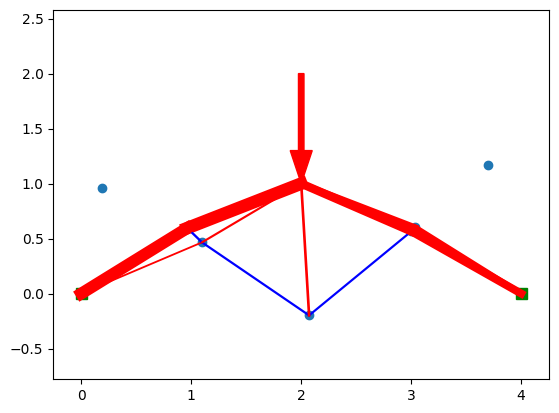

In [437]:
from IPython import display
import time


for _ in range(200):
    cost = t.get_cost()
    # print(cost.item())
    t.draw()
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    # time.sleep(1)



In [51]:
t.node_tensors

[tensor([0., 0.], dtype=torch.float64, requires_grad=True),
 tensor([0., 1.], dtype=torch.float64, requires_grad=True),
 tensor([1., 0.], dtype=torch.float64, requires_grad=True),
 tensor([1., 1.], dtype=torch.float64, requires_grad=True),
 tensor([2., 0.], dtype=torch.float64, requires_grad=True),
 tensor([2., 1.], dtype=torch.float64),
 tensor([3., 0.], dtype=torch.float64, requires_grad=True),
 tensor([3., 1.], dtype=torch.float64, requires_grad=True),
 tensor([4., 0.], dtype=torch.float64, requires_grad=True),
 tensor([4., 1.], dtype=torch.float64, requires_grad=True)]

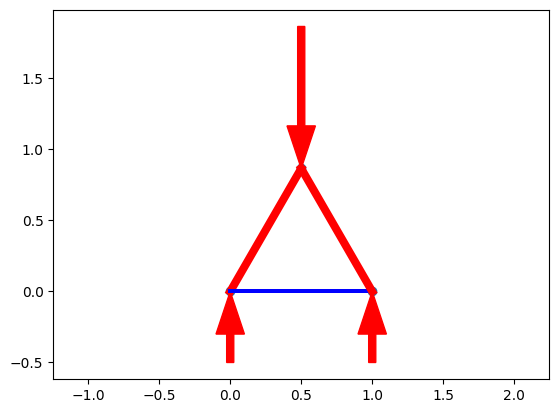

In [6]:
# Equilateral triangle test with pure forces
node_tensors = np.array((
    (0.5, np.sin(2*np.pi/3)),
    (0, 0), 
    (1, 0),
))
edges = np.array(((0,1), (1, 2), (2, 0)))
t = Truss(node_tensors, edges)

t.add_load(0, 0, -10)
t.add_load(1, 0, 5)
t.add_load(2, 0, 5)

forces = t.calculate_forces()
t.draw()
expected = np.array([[5.77350269, -2.88675135, 5.77350269]]).T
assert sum((forces - expected)**2) < 0.001

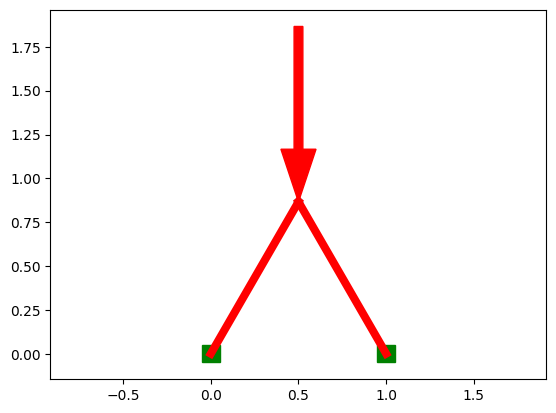

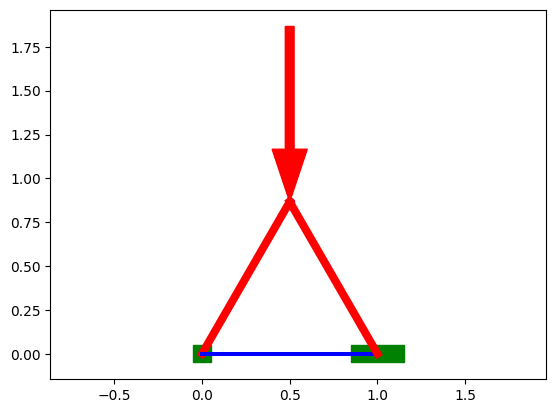

In [15]:
# Equilateral triangle test with anchors
node_tensors = np.array((
    (0.5, np.sin(2*np.pi/3)),
    (0, 0), 
    (1, 0),
))
edges = np.array(((0,1), (1, 2), (2, 0)))

# two full anchors
t = Truss(node_tensors, edges)
t.add_load(0, 0, -10)
t.add_anchor(1)
t.add_anchor(2)

forces = t.calculate_forces()
t.draw()
expected = torch.tensor([[5.77350269, 0, 5.77350269]]).T
assert sum((forces - expected)**2) < 0.001

# 1 partial anchor
t = Truss(node_tensors, edges)

t.add_load(0, 0, -10)
t.add_anchor(1)
t.add_anchor(2, x=False)

forces = t.calculate_forces()
t.draw()
expected = torch.tensor([[5.77350269, -2.88675135, 5.77350269]]).T
assert sum((forces - expected)**2) < 0.001

correctly threw error


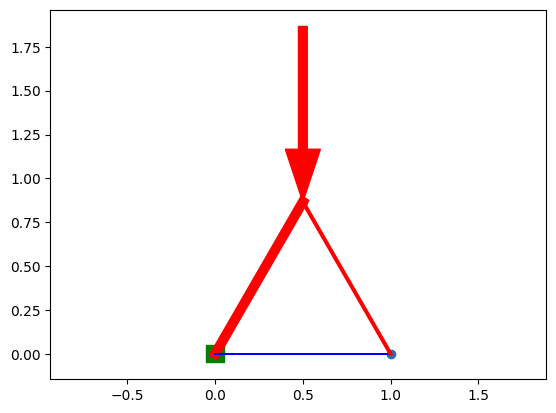

In [17]:
# under constrained example
node_tensors = np.array((
    (0.5, np.sin(2*np.pi/3)),
    (0, 0), 
    (1, 0),
))
edges = np.array(((0,1), (1, 2), (2, 0)))

# two full anchors
t = Truss(node_tensors, edges)
t.add_load(0, 0, -10)
t.add_anchor(1)
# t.add_anchor(2)

try:
    forces = t.calculate_forces()
    assert False, "should have thrown value error"
except ValueError:
    print("correctly threw error")
t.draw()

tensor([[2.7348, 3.4813, 5.0138]], grad_fn=<PermuteBackward0>)


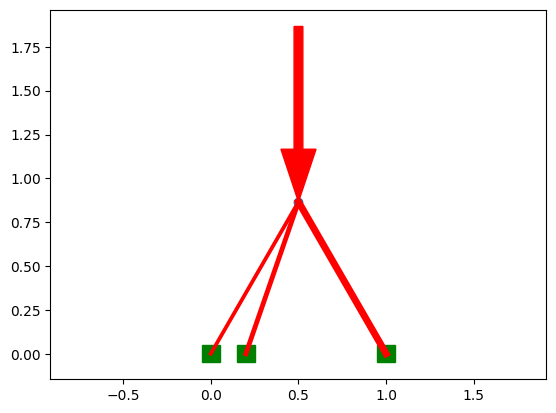

In [18]:
# Over constrained example
node_tensors = np.array((
    (0.5, np.sin(2*np.pi/3)),
    (0, 0), 
    (.2, 0),
    (1, 0),
))
edges = np.array(((0,1), (0, 2), (0, 3)))

# two full anchors
t = Truss(node_tensors, edges)
t.add_load(0, 0, -10)
t.add_anchor(1)
t.add_anchor(2)
t.add_anchor(3)

forces = t.calculate_forces()
t.draw()
print(forces.T)
assert all(forces > 2.0), "force should be among all beams"

cost: 18.282764434814453


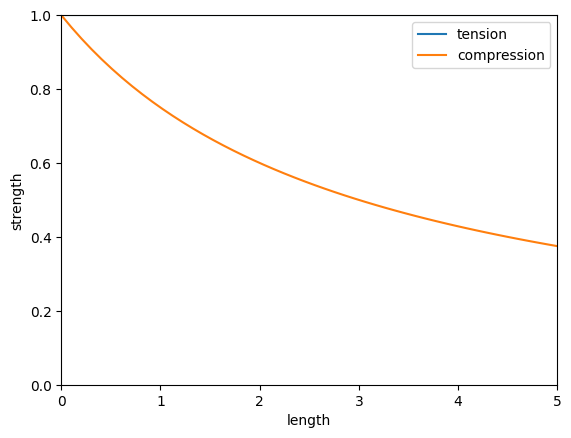

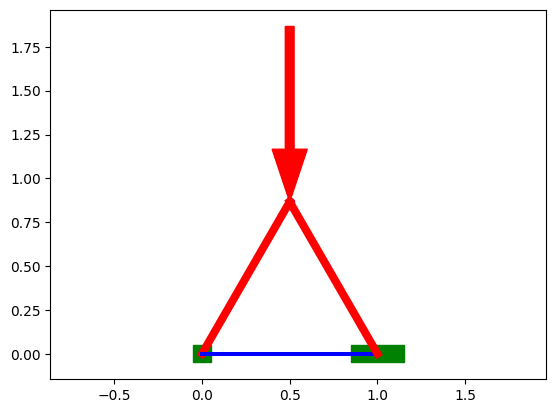

In [20]:
# How strong is a beam of different length?
lengths = np.linspace(0,5, 50)
tensions = np.ones_like(lengths)
fall_off = 3.0
compressions = fall_off / (lengths + fall_off)

plt.plot(lengths, tensions, label='tension')
plt.plot(lengths, compressions, label='compression')
plt.axis((0,5,0,1))
plt.xlabel("length")
plt.ylabel("strength")
plt.legend()

node_tensors = np.array((
    (0.5, np.sin(2*np.pi/3)),
    (0, 0), 
    (1, 0),
))
edges = np.array(((0,1), (1, 2), (2, 0)))

t = Truss(node_tensors, edges)

t.add_load(0, 0, -10)
t.add_anchor(1)
t.add_anchor(2, x=False)

print(f"cost: {t.get_cost()}")
t.draw()